# PRODUCT RECOGNITION ON STORE SHELVES

### Manuel Gabrielli - manuel.gabrielli@studio.unibo.it


---


Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:
1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).

<img src="img/imageAssignment1.png" width="520"><br>

3. Position in the image reference system of each instance (center of the bounding box that enclose them in pixel).

For example, as output of the above image the system should print:

<img src="Img/imageAssignment2.png" width="700"><br>

## Step A - Multiple Product Detection

- Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}
- Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 25.jpg, 26.jpg}

Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. 

The system should be able to correctly identify all the product in the shelves
image.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
def readImages():
    #open and conversion to original colours
    images = {}
    for i in range(num_models):
        img = cv2.imread(models_path+str(model_index[i])+models_estenstion);
        images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
    
    #open and conversion to original colours
    scenes = {}
    for i in range(num_scenes):
        img = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion);
        scenes[i] = cv2.cvtColor(img,cv2.COLOR_BGR2RGB);
        
    return images, scenes

In [3]:
def getKeypoints(image):
    # find the keypoints and descriptors with SIFT
    kp_image = sift.detect(image)
    
    # Describing keypoints for image
    kp_image, des_image = sift.compute(image, kp_image)
    
    return kp_image, des_image

In [4]:
def getFeatureMatcher():
    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    return flann

In [5]:
# the centroid or geometric center of a plane figure is the arithmetic mean position of all the points in the shape.
#calculated by the sum of the x coord divided by the number and the sum of y coord dividend by the number
def getCentroid(vertices):
    sum_coord = [0,0]
    for i in range(len(vertices)):
        sum_coord = sum_coord + vertices[i][0]
    return (int(sum_coord[0]/len(vertices)), int(sum_coord[1]/len(vertices)))

In [6]:
def printResults(occurences, scene_name): 
    print("Scene "+scene_name+":\n")
    
    for o in occurences.keys():
        print("\nProduct {} - {} instance found:\n".format(o, len(occurences[o])))

        #[{'height': 438, 'width': 310, 'center': (162, 214)}]

        listOcc = occurences[o]

        for i in range(len(listOcc)):
            center = listOcc[i]["center"]
            height = listOcc[i]["height"]
            width = listOcc[i]["width"]
            print("\tInstance "+str(i+1)+": {position: ("+str(center[0])+","+str(center[1])+"), width: "+str(width)+"px, heigh: "+str(height)+"px}")


In [7]:
def findPerimetersTemplates(goodKeypoints, models, scene, i, kp_scene):
    
    per_check = []
    
    if len(goodKeypoints)>MIN_MATCH_COUNT:

            # building the corrspondences arrays of good matches
            src_pts = np.float32([ kp_models[i][m.queryIdx].pt for m in goodKeypoints ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in goodKeypoints ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Corners of the query image
            h,w = models[i].shape[0:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)

            #FACENDO IL CONTROLLO SUL COLORE DELL'AREA CAPISCONO QUALI SONO LE SCATOLE PRESENTI E QUALI NO

            #controlla che la scatola non sia troppo inclinata, e quindi storpiata
            if ((abs(dst[0,0][0]-dst[1,0][0])<LIMIT_INC) and abs(dst[0,0][1]-dst[3,0][1])<LIMIT_INC 
                and abs(dst[2,0][0]-dst[3,0][0])<LIMIT_INC and abs(dst[1,0][1]-dst[2,0][1])<LIMIT_INC):

                #if dealing with chocokrave (correct model)
                if (model_index[i] == 1 or model_index[i]==11):
                    dst= np.int32(dst)+(0,30)

                #cambio le coordinate per non avere indici negativi o indici che eccedono la dimensione dell'immagine
                x_min=int((dst[0,0][0]+dst[1,0][0])/2)
                if(x_min<0):
                    x_min=0
                if(x_min>=scene.shape[1]): #se esce dalla figura perchè è maggiore della dimensione della scena lo metto a uno 
                    x_min=scene.shape[1]-1 #in meno rispetto alla dimensione della scena
                y_min=int((dst[0,0][1]+dst[3,0][1])/2)
                if(y_min<0):
                    y_min=0
                if(y_min>=scene.shape[0]):
                    y_min=scene.shape[0]-1
                x_max=int((dst[2,0][0]+dst[3,0][0])/2)
                if(x_max<0):
                    x_max=0
                if(x_max>=scene.shape[1]):
                    x_max=scene.shape[1]-1
                y_max=int((dst[1,0][1]+dst[2,0][1])/2)
                if(y_max<0):
                    y_max=0
                if(y_max>=scene.shape[0]):
                    y_max=scene.shape[0]-1

                #escludo il primo terzo
                #calcolo max_y(y2)-min_y(y1)/3 e sommo y_1 per traslarlo
                start_row = int(y_min+(y_max-y_min)/3)

                #control over the colour of a significant area
                area = scene[start_row:y_max, x_min:x_max]

                #se l'area selezionata non è vuota
                if(area.shape[0] != 0 and area.shape[1]!= 0):
                    average_area_row = np.average(area, axis=0)
                    average_area = np.average(average_area_row, axis=0).astype(int).tolist()

                    #print(accum_area, ref_colour[i])

                    color_first=abs(average_colors[i][0]-average_area[0])
                    color_second=abs(average_colors[i][1]-average_area[1])
                    color_third=abs(average_colors[i][2]-average_area[2])

                    #check on colour mean
                    #la differenza tra il colore primario ottenuto dell'area e quello del modello deve essere entro certi parametri
                    DIFF_COLOUR = 30
                    #la differenza tra il colore primario ottenuto dell'area e quello del modello deve essere entro certi parametri
                    if(color_first < DIFF_COLOUR and color_second < DIFF_COLOUR and color_third < DIFF_COLOUR):
                            
                        width = int(round(dst[2,0][0] - dst[0,0][0]))
                        height = int(round(dst[1,0][1] - dst[0,0][1]))
                        lower_width = int(round(dst[3,0][0] - dst[1,0][0]))
                        lower_height = int(round(dst[2,0][1] - dst[3,0][1]))
                        perimeter=width+lower_width+height+lower_height
                        per_check.append({"index":model_index[i],"perimeter":perimeter, "dst":dst})
    
    return per_check    

In [8]:
def searchTemplates_A(models, scene):
    # Describing keypoints for scene image
    kp_scene, des_scene = getKeypoints(scene)

    matches = {}
    good = {}
    
    for i in range(len(models)):
        # Matching and finding the 2 closest elements for each query descriptor.
        matches[i] = flann.knnMatch(des_models[i],des_scene,k=2)
        
        good[i] = []
        for m,n in matches[i]:
            if m.distance < 0.7*n.distance:
                good[i].append(m)


    per_check = []
    #loop over all the possible models
    for i in range(len(models)):
        per_check.extend(findPerimetersTemplates(good[i], models, scene, i, kp_scene))
    
    return per_check

In [9]:
def drawResults(scene, per_check, scene_name):
    
    current_index = -1
    occurences = {}
    
    per = []
    for i in range(len(per_check)):
        per.append(per_check[i]["perimeter"])
    median_p = np.median(per)
    
    for i in range(len(per_check)):
        perimeter = per_check[i]["perimeter"]
        
        #se il perimetro rientra dentro un certo range possibili di valori
        if(range_perimeter[0]*median_p < perimeter < range_perimeter[1]*median_p):
            dst = per_check[i]["dst"]
            model_ind = per_check[i]["index"]

            if(current_index != model_ind):
                current_index = model_ind
                occurences[current_index] = []

            text = model_texts[model_ind]

            # Drawing the bounding box
            scene = cv2.polylines(scene,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)

            (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=3)[0]
            offset_1=(int(dst[1,0][0]), int(dst[1,0][1])+10)
            offset_2=(int(dst[2,0][0]), int(dst[1,0][1])-text_height-5)
            cv2.rectangle(scene,offset_1, offset_2, (0,255,0), cv2.FILLED)
            width = int(round(dst[2,0][0] - dst[0,0][0]))
            height = int(round(dst[1,0][1] - dst[0,0][1]))
            #centered position of the text wrt the rectangle
            org = (int(dst[1,0][0]+(width/2-text_width/2)), int(dst[1,0][1])) 
            cv2.putText(scene,text,org, font, font_scale,(0,0,0),3,cv2.LINE_AA)

            #get center of the box
            center = getCentroid(dst)

            occurences[current_index].append({"height": height, "width": width, "center": center})

    #stampo i risultati ottenuti
    printResults(occurences, scene_name)
    
    #print scene image
    plt.figure(figsize=(20, 10))
    plt.imshow(scene);
    plt.show();

In [10]:
#PARAMETERS

#MODEL IMAGES
model_index = {
    0: 0,
    1: 1,
    2: 11,
    3: 19,
    4: 24,
    5: 25,
    6: 26
}

model_texts = {
    0: "Nesquik",
    1: "CK Blue",
    11: "CK Orange",
    19: "Country Crisp",
    24: "Fitness",
    25: "Coco Pops",
    26: "Nesquik Duo",
}

models_estenstion = ".jpg"

models_path = "models/"

num_models = len(model_index);

#SCENES IMAGES
scenes_names = ["e1", "e2", "e3", "e4", "e5"]

scenes_estenstion = ".png"

scene_path = "scenes/"

num_scenes = len(scenes_names)

#MACRO VARIABLES
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale=1.0

# Checking if we found enough matching
MIN_MATCH_COUNT = 30
range_perimeter = (0.8,1.4)
LIMIT_INC = 35

In [11]:
images, scenes = readImages()

#get avarage colour of each model image
average_colors = {}

for i in range(num_models):
    #non considero il primo terzo dell'immagine che molte volte contiene il logo della marca
    start_row = int(images[i].shape[0]/3)
    #seleziono la parte dell'imagine da considerare
    selected_image = images[i][start_row: images[i].shape[0], :]
    #faccio la media
    average_color_row = np.average(selected_image, axis=0)
    average_colors[i] = np.average(average_color_row, axis=0).astype(int).tolist()

# Initiate SIFT detector
sift = cv2.SIFT_create()
flann = getFeatureMatcher()

kp_models = {}
des_models = {}

for i in range(num_models):
    # Describing keypoints for model images
    kp_models[i], des_models[i] = getKeypoints(images[i])

Scene e1:


Product 0 - 1 instance found:

	Instance 1: {position: (162,215), width: 310px, heigh: 439px}

Product 11 - 1 instance found:

	Instance 1: {position: (442,197), width: 299px, heigh: 393px}


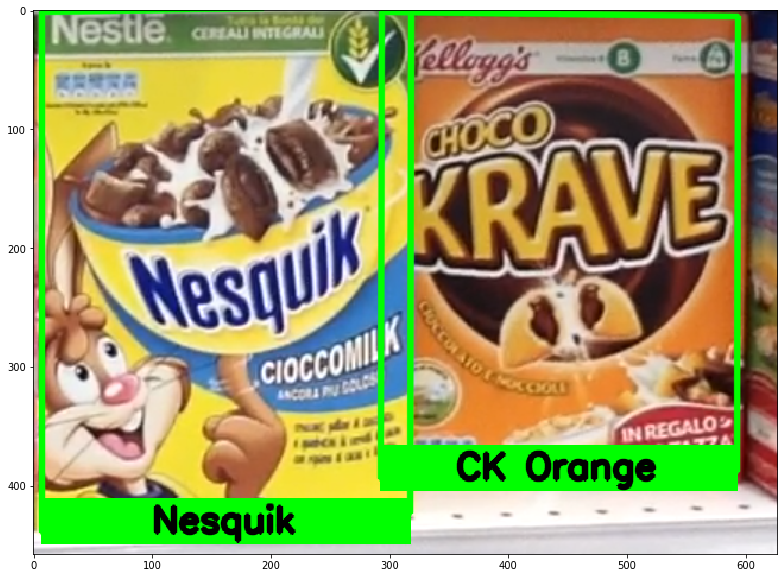

Scene e2:


Product 24 - 1 instance found:

	Instance 1: {position: (167,219), width: 340px, heigh: 490px}

Product 25 - 1 instance found:

	Instance 1: {position: (878,232), width: 303px, heigh: 445px}

Product 26 - 1 instance found:

	Instance 1: {position: (538,218), width: 330px, heigh: 490px}


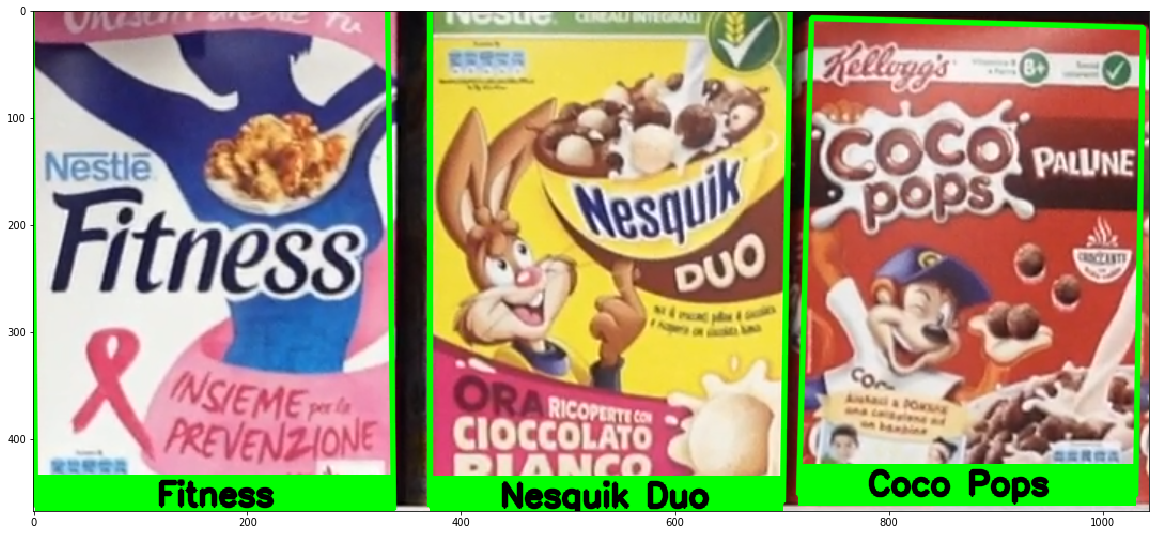

Scene e3:


Product 0 - 1 instance found:

	Instance 1: {position: (170,236), width: 327px, heigh: 445px}

Product 11 - 1 instance found:

	Instance 1: {position: (474,218), width: 304px, heigh: 398px}


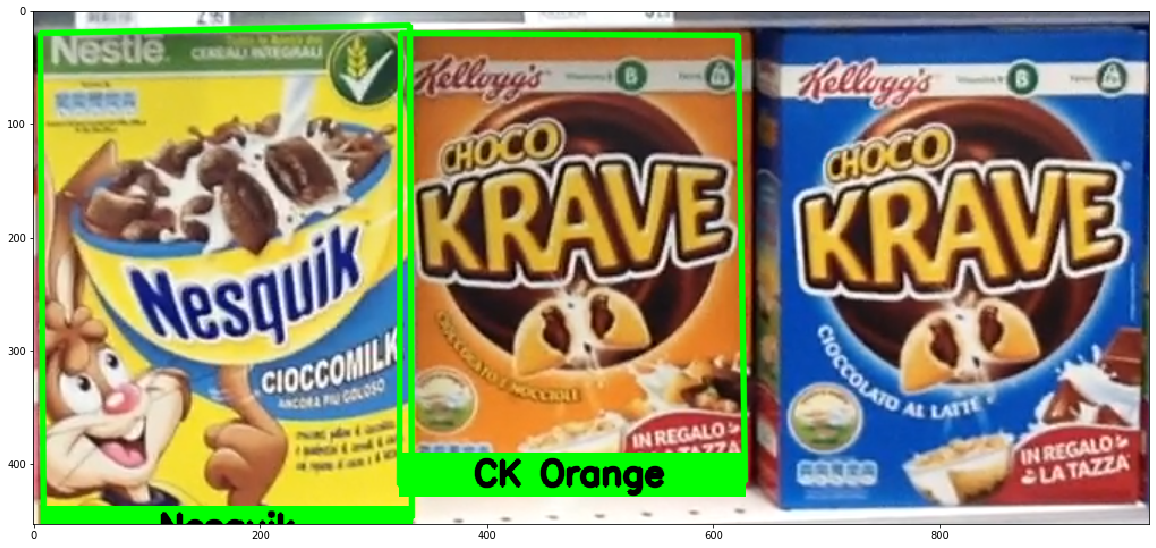

Scene e4:


Product 0 - 1 instance found:

	Instance 1: {position: (158,739), width: 327px, heigh: 445px}

Product 11 - 1 instance found:

	Instance 1: {position: (461,721), width: 304px, heigh: 402px}

Product 25 - 1 instance found:

	Instance 1: {position: (555,208), width: 316px, heigh: 448px}

Product 26 - 1 instance found:

	Instance 1: {position: (205,195), width: 343px, heigh: 497px}


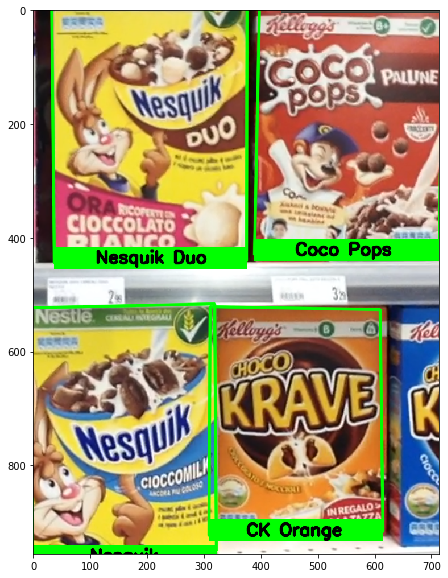

Scene e5:


Product 19 - 1 instance found:

	Instance 1: {position: (503,190), width: 290px, heigh: 386px}

Product 25 - 1 instance found:

	Instance 1: {position: (161,227), width: 312px, heigh: 444px}


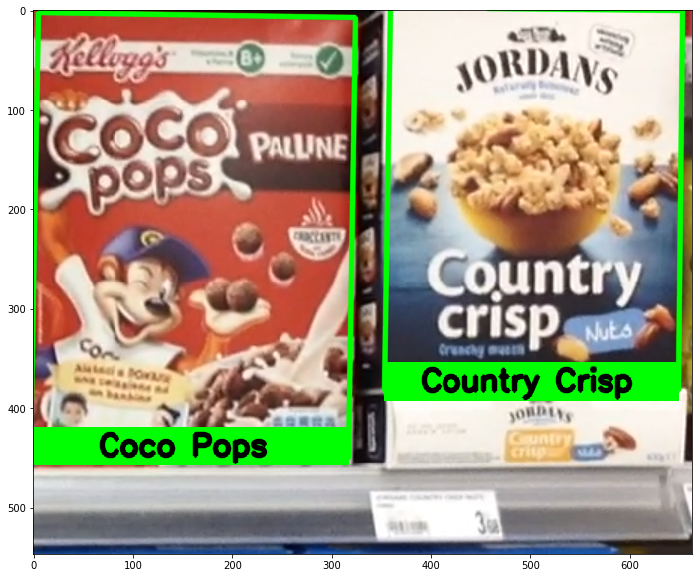

In [12]:
for i in range(num_scenes):
    #creo una copia della scena da modificare
    copy_scene = np.copy(scenes[i])
    per_check = searchTemplates_A(images, copy_scene)
    drawResults(copy_scene, per_check, scenes_names[i])

## Step B - Multiple Instance Detection

- Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}
- Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In addition to what achieved at step A, the system should now be able to detect multiple instance of the
same product.

In [13]:
def readGrayImages():
    grey_scenes = {}
    for i in range(num_scenes):
        grey_scenes[i] = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion, 0);
        
    return grey_scenes

In [14]:
def computeBarycenter(kp_query):
    sum_x = 0
    sum_y = 0
    for i in range(len(kp_query)):
        sum_x = sum_x + kp_query[i].pt[0]
        sum_y = sum_y + kp_query[i].pt[1]
    bar = (int(sum_x/len(kp_query)), int(sum_y/len(kp_query)))
    return bar

In [15]:
def computeVectors(kp_models, barycenter):
    vectors = {}
    for i in range(len(kp_models)):
        vectors[i] = (barycenter[0] - kp_models[i].pt[0], barycenter[1] - kp_models[i].pt[1])
    return vectors

In [16]:
def voting(imageShape, dst_points, vectors, ind_model):
    votes = []
    acc = np.zeros(imageShape)
    for j in range(len(dst_points)): 
        #dst_points[j][1] indice del kp_model associato al kp_train
        vec = vectors[dst_points[j][1]]
       
        diff_scale = dst_points[j][0].size/kp_models[ind_model][dst_points[j][1]].size
        
        vec = (diff_scale*vec[0], diff_scale*vec[1])
        
        vote = [sum(tup) for tup in zip(dst_points[j][0].pt, vec)]
        
        #controllo se esce dall'immagine
        if(vote[0]>= 0 and vote[0]<= imageShape[1] and vote[1]>= 0 and vote[1] <= imageShape[0]):
            acc[int(vote[1]), int(vote[0])] += 1
            votes.append([dst_points[j][0], (int(vote[0]), int(vote[1]))])
           
    return acc, votes

In [17]:
def getPossibleBarycenters(accumulator, min_votes):
    barycenters=[]
    row, col = accumulator.shape
    
    for i in range(row):
        for j in range(col):
            #servono min_votes voti per essere considerato un poteziale baricentro
            if(accumulator[i,j]>= min_votes):
                barycenters.append([j,i])
    return barycenters

In [18]:
#function to filter barycentres list according to votes in their neighbourhood
def outliersFilter(filtered_bar, accumulator, RANGE, MIN_COUNT):
    
    res = filtered_bar.copy()
    row, col = accumulator.shape
    removed_bar = []
    count = 0
    
    for k in range(len(res)):
        start_row = filtered_bar[k][1] - RANGE
        start_col = filtered_bar[k][0] - RANGE
        end_row = filtered_bar[k][1] + RANGE
        end_col = filtered_bar[k][0] + RANGE

        #controllo che non escano dai limiti dell'immagine
        if (end_row > row):
            end_row = row
        if (start_row < 0):
            start_row = 0

        if (end_col > col):
            end_col = col
        if (start_col < 0):
            start_col = 0

        for i in range(start_row, end_row):
            for j in range(start_col, end_col):
                if (accumulator[i, j] > 1):
                    count = count + accumulator[i, j]
       
        #se è minore lo aggiungo agli elementi da rimuovere
        if count < MIN_COUNT:
            removed_bar.append(filtered_bar[k])
        count = 0

    for i in removed_bar:
        res.remove(i)
    
    return res

In [19]:
#function to compute euclidian distance
def euclidianDistance(point_1,point_2):
    dist = np.sqrt((point_1[0]-point_2[0])**2+(point_1[1]-point_2[1])**2)
    return dist

In [20]:
#function to filter a barycentres list making mean between closest ones
def distanceFilter(barycentres, distance):
    filtered_bar = []
    len_bar = len(barycentres)
    
    for i in range(len_bar):
        
        if (barycentres[i] != [-1,-1]):
            sum_b = barycentres[i].copy()
            count_b = 1
            next_index=i+1
            
            for j in range(next_index,len_bar):
                #non faccio il confronto con uno già stato analizzato
                if(barycentres[j] != [-1,-1]):
                    
                    dist = euclidianDistance(barycentres[i],barycentres[j])
                    #qui crea un nuovo baricentro facendo la media tra quelli trovati
                    if(dist<distance):
                        sum_b[0] = sum_b[0]+barycentres[j][0]
                        sum_b[1] = sum_b[1]+barycentres[j][1]
                        barycentres[j] = [-1,-1] #lo metto uguale a [-1,-1] così poi non viene più analizzato
                        count_b += 1
                
            #alla fine faccio la media
            sum_b[0] = int(round(sum_b[0] / count_b))
            sum_b[1] = int(round(sum_b[1] / count_b))
            filtered_bar.append(sum_b)
                    
    return filtered_bar

In [21]:
def getCorrectKeypoints(bar_found, votes, imageShape, good, RANGE):
    final_good=[]
    
    for vote in votes:
        bar_x, bar_j = (int(vote[1][0]), int(vote[1][1]))
      
        if (0 < bar_x < imageShape[1] and 0 <bar_j < imageShape[0]):
            if((bar_found[0]-RANGE < bar_x < bar_found[0]+RANGE) 
               and (bar_found[1]-RANGE < bar_j < bar_found[1]+RANGE)):
                final_good.append(good.get(vote[0]))
                
    return final_good

In [22]:
def generalizedHoughTransform(grey_scene, models, des_scene):
    
    #qui è dove si salva l'elenco di tutti i baricentri per ogni modello nella scena
    barycenters_list = {}
    final_good = {}
    threshold = 0.8
    min_votes = 2
    range_outliers = 20
    count_outliers = 2
    distance = 100
    range_final_keypoints = 50
    
    for i in range(len(models)):
        # Matching and finding the 2 closest elements for each query descriptor.
        matches = flann.knnMatch(des_models[i],des_scene,k=2)
    
        #get first good matches
        good = {}
        for m,n in matches:
            if m.distance < threshold*n.distance:
                good[kp_scene[m.trainIdx]] =  m
            
            
        #get points matchati nella immagine di train
        #dst_points sono nell'ordine scritto in good
        dst_points = []
        for k,m in good.items():
            dst_points.append((k, m.queryIdx))
            #dst_points.append((k, m.queryIdx))
    
        
        accumulator, votes = voting(grey_scene.shape, dst_points, vectors[i], i)
        
        possible_b = getPossibleBarycenters(accumulator, min_votes)
       
        #First filter to discard outliers
        filtered_bar = outliersFilter(possible_b,accumulator, range_outliers, count_outliers)

        #Second filter to obtain a single barycenter from a group of close barycenters
        barycenters_list[i] = distanceFilter(filtered_bar, distance)

        #Find now the right "good" vectors
        final_good[i] = {}
        for j in range(len(barycenters_list[i])):
            final_good[i][j]= getCorrectKeypoints(barycenters_list[i][j], votes, grey_scene.shape, good, range_final_keypoints)
        
    return barycenters_list, final_good

In [23]:
def searchTemplates_B(models, scene, kp_scene, barycenters, final_good, LIMIT_INC):
    
    per_check = []
    #loop over all the possible models
    for i in range(len(models)):

        for j in range(len(barycenters[i])):
            
            per_check.extend(findPerimetersTemplates(final_good[i][j], models, scene, i, kp_scene))

    return per_check

In [24]:
#PARAMETERS

#SCENES IMAGES
scenes_names = ["m1","m2","m3","m4","m5"]

num_scenes = len(scenes_names)

# Checking if we found enough matching
MIN_MATCH_COUNT = 10
range_perimeter = (0.82,1.4)
LIMIT_INC = 55

In [25]:
images, scenes = readImages()
grey_scenes = readGrayImages()

barycenters = {}
vectors = {}

for i in range(num_models):
    barycenters[i] = computeBarycenter(kp_models[i])
    vectors[i] = computeVectors(kp_models[i], barycenters[i])

Scene m1:


Product 24 - 2 instance found:

	Instance 1: {position: (184,214), width: 363px, heigh: 503px}
	Instance 2: {position: (550,219), width: 340px, heigh: 488px}

Product 25 - 1 instance found:

	Instance 1: {position: (1261,232), width: 303px, heigh: 446px}

Product 26 - 2 instance found:

	Instance 1: {position: (921,218), width: 330px, heigh: 490px}
	Instance 2: {position: (921,218), width: 330px, heigh: 491px}


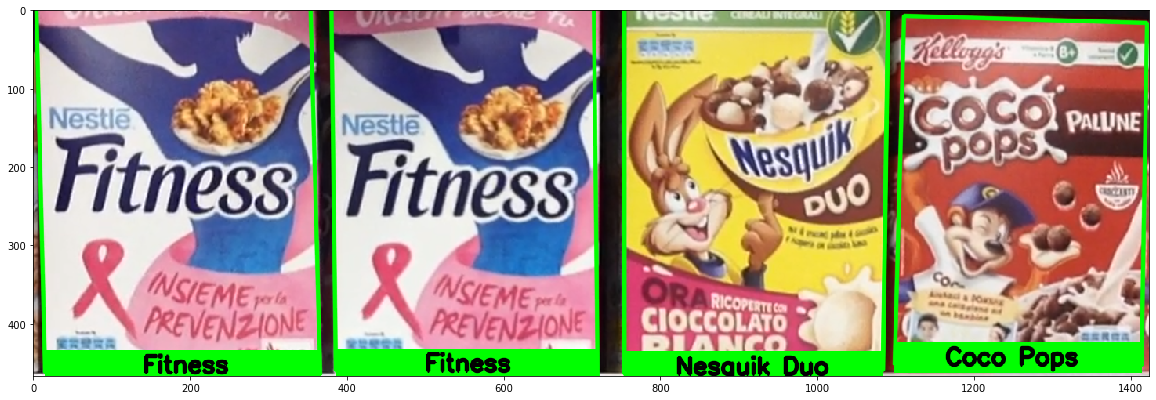

Scene m2:


Product 0 - 1 instance found:

	Instance 1: {position: (178,300), width: 348px, heigh: 453px}

Product 1 - 2 instance found:

	Instance 1: {position: (1180,284), width: 297px, heigh: 417px}
	Instance 2: {position: (847,289), width: 313px, heigh: 415px}

Product 11 - 1 instance found:

	Instance 1: {position: (511,274), width: 308px, heigh: 319px}


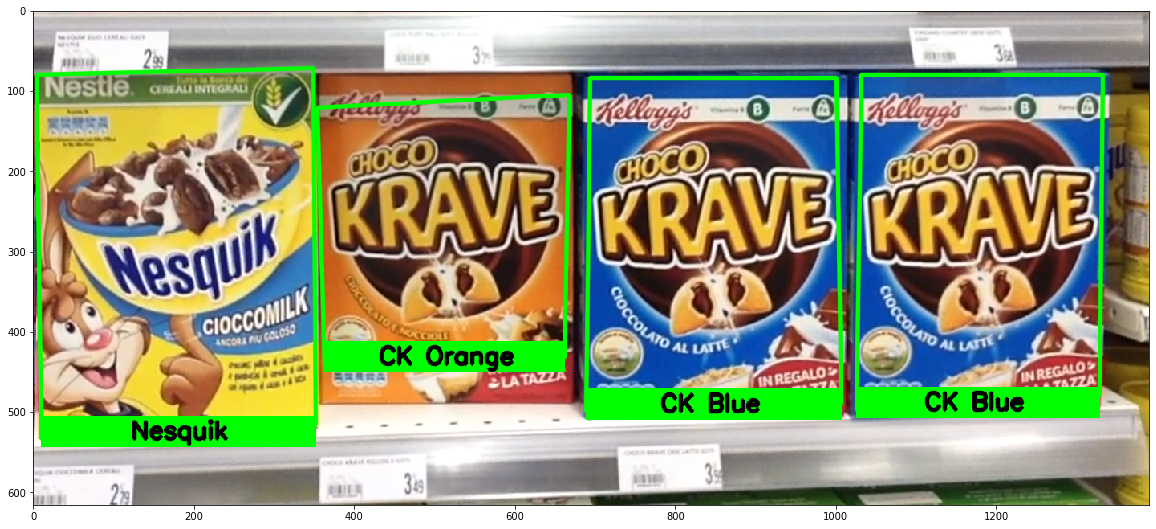

Scene m3:


Product 19 - 1 instance found:

	Instance 1: {position: (1233,189), width: 291px, heigh: 386px}

Product 25 - 2 instance found:

	Instance 1: {position: (890,226), width: 311px, heigh: 442px}
	Instance 2: {position: (558,221), width: 331px, heigh: 455px}

Product 26 - 1 instance found:

	Instance 1: {position: (195,206), width: 364px, heigh: 509px}


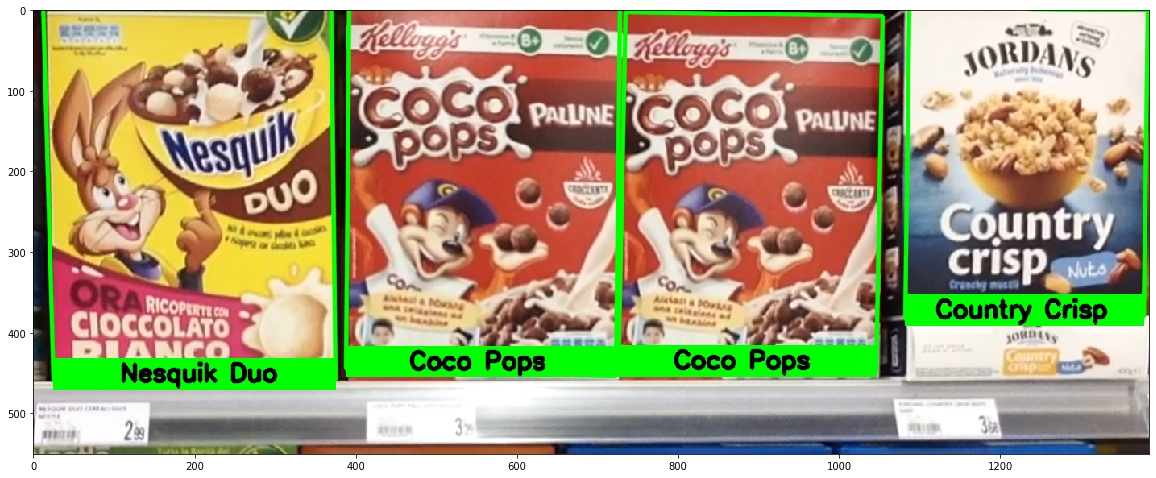

Scene m4:


Product 24 - 2 instance found:

	Instance 1: {position: (161,192), width: 380px, heigh: 506px}
	Instance 2: {position: (540,196), width: 359px, heigh: 501px}

Product 25 - 1 instance found:

	Instance 1: {position: (1589,209), width: 297px, heigh: 431px}

Product 26 - 1 instance found:

	Instance 1: {position: (921,195), width: 343px, heigh: 498px}


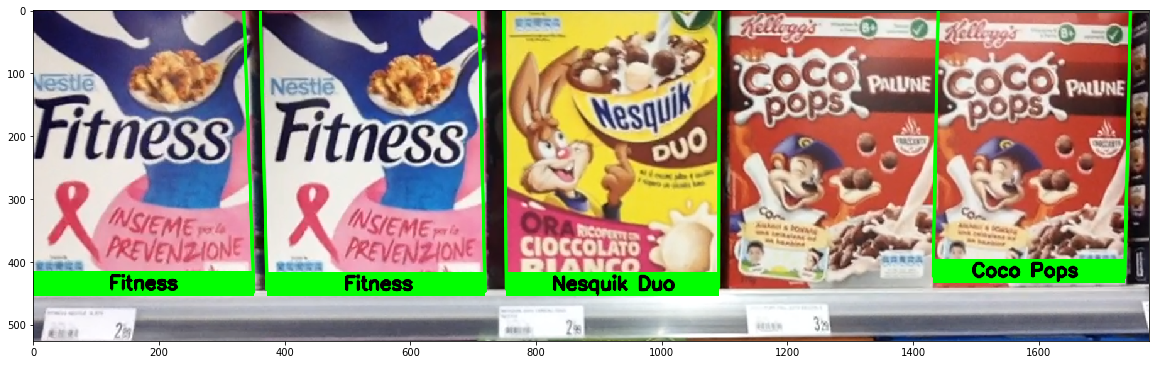

Scene m5:


Product 1 - 2 instance found:

	Instance 1: {position: (500,751), width: 314px, heigh: 414px}
	Instance 2: {position: (833,748), width: 297px, heigh: 411px}

Product 11 - 1 instance found:

	Instance 1: {position: (162,739), width: 310px, heigh: 401px}

Product 19 - 1 instance found:

	Instance 1: {position: (908,190), width: 291px, heigh: 387px}

Product 25 - 2 instance found:

	Instance 1: {position: (235,223), width: 334px, heigh: 457px}
	Instance 2: {position: (566,228), width: 313px, heigh: 446px}


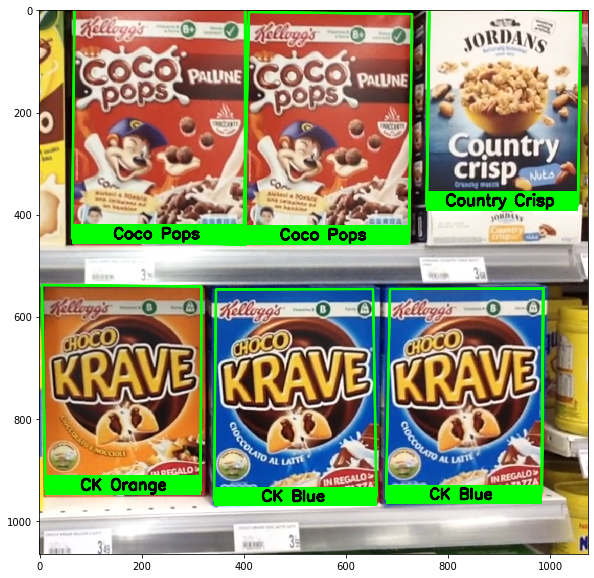

In [26]:
for i in range(num_scenes):
    #creo una copia della scena da modificare
    copy_scene = np.copy(scenes[i])
    kp_scene = sift.detect(grey_scenes[i])
    kp_scene, des_scene = sift.compute(grey_scenes[i], kp_scene)
    barycenters_list, final_good = generalizedHoughTransform(grey_scenes[i], images, des_scene)
    per_check = searchTemplates_B(images, copy_scene, kp_scene, barycenters_list, final_good, LIMIT_INC)
    drawResults(copy_scene, per_check, scenes_names[i])

# Correction Step A

Scene e3:


Product 0 - 1 instance found:

	Instance 1: {position: (170,236), width: 327px, heigh: 445px}

Product 1 - 1 instance found:

	Instance 1: {position: (817,222), width: 304px, heigh: 408px}

Product 11 - 1 instance found:

	Instance 1: {position: (474,220), width: 305px, heigh: 395px}


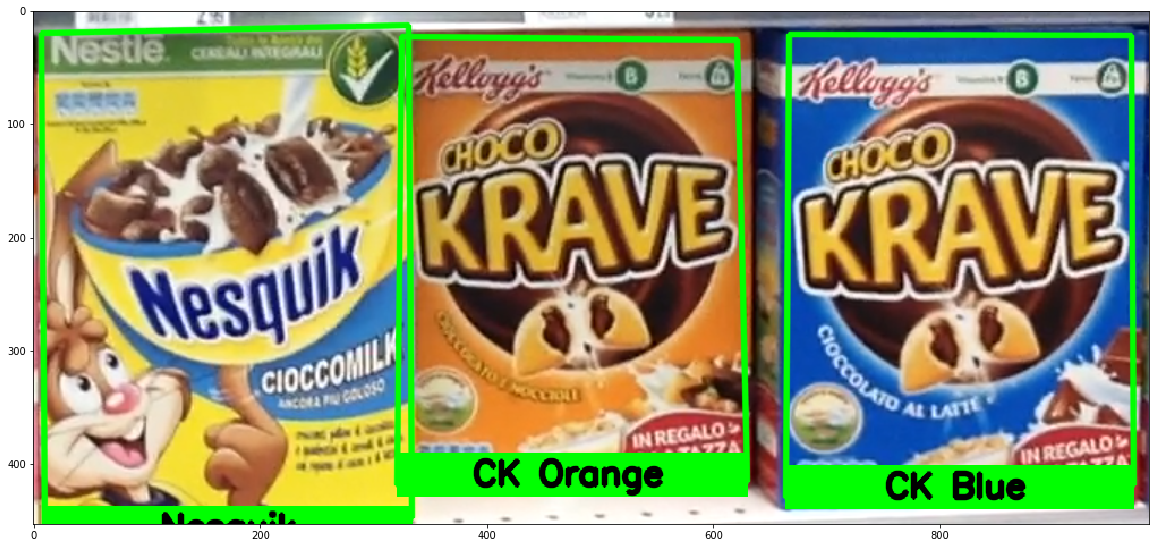

In [28]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 30

scene_name = "e3"


scene =  cv2.imread(scene_path+scene_name+scenes_estenstion);
scene = cv2.cvtColor(scene,cv2.COLOR_BGR2RGB);
grey_scene = cv2.imread(scene_path+scene_name+scenes_estenstion, 0);
        

#creo una copia della scena da modificare
copy_scene = np.copy(scene)
kp_scene = sift.detect(grey_scene)
kp_scene, des_scene = sift.compute(grey_scene, kp_scene)
barycenters_list, final_good = generalizedHoughTransform(grey_scene, images, des_scene)
per_check = searchTemplates_B(images, copy_scene, kp_scene, barycenters_list, final_good, LIMIT_INC)
drawResults(copy_scene, per_check, scene_name)